In [1481]:
import os
os.environ['PYTHONHASHSEED'] = '123'

import random
import numpy as np
import tensorflow as tf
import pandas as pd

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

close = pd.read_csv("close_data.csv")
close.index = pd.to_datetime(close['Date'], format='%Y-%m-%d')
close = close.drop('Date', axis=1)

close

,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2024-04-09,168.872604,185.669998,414.690002,155.854858,147.556274,515.021118,423.050171,85.325951,176.880005,274.670776
2024-04-10,166.991470,185.949997,409.109985,155.397064,145.531250,517.940552,420.053040,87.010406,171.759995,272.447388
2024-04-11,174.217377,189.050003,407.609985,158.651505,144.165054,521.258362,424.687653,90.586227,174.600006,273.638489
2024-04-12,175.720276,186.130005,403.260010,156.979507,142.934540,510.039307,418.703369,88.157028,171.050003,273.916412
2024-04-15,171.878403,183.619995,400.260010,154.123154,143.002350,498.411743,410.505951,85.972748,161.479996,269.271088
...,...,...,...,...,...,...,...,...,...,...
2025-04-03,203.190002,178.410004,530.159973,150.720001,159.820007,531.619995,373.109985,101.800003,267.279999,339.390015
2025-04-04,188.380005,171.000000,493.540009,145.600006,153.240005,504.730011,359.839996,94.309998,239.429993,313.130005
2025-04-07,181.460007,175.259995,490.380005,146.750000,150.619995,516.250000,357.859985,97.639999,233.289993,312.320007


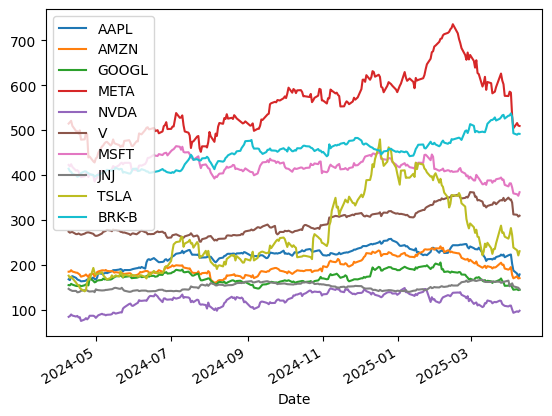

In [1482]:
stock_to_use = 'BRK-B'
stocks = ['AAPL', 'AMZN', 'BRK-B', 'GOOGL', 'META', 'NVDA', 'V', 'MSFT', 'JNJ', 'TSLA']

if stock_to_use in stocks:
    stocks.remove(stock_to_use)
else:
    print('ERROR')

stocks.append(stock_to_use)

stock_data = []

for i in stocks:
    stock_data.append(close[i])
    close[i].plot(label=i)

plt.legend()
#stock = close[stock_to_use]
#stock.plot()

In [1483]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 15

X1 = np.array([])
y1 = np.array([])
for i in stock_data:
  X_temp, y_temp = df_to_X_y(i, WINDOW_SIZE)
  X1 = list(X1) + list(X_temp)
  y1 = np.concatenate((y1, y_temp))

#X1, y1 = df_to_X_y(stock, WINDOW_SIZE) ((247, 5, 1), (247,))
X1 = np.array(X1)
y1 = np.array(y1)
X1.shape, y1.shape

observations_in_one_stock = int(X1.shape[0]/len(stocks))
observations_in_one_stock



237

In [1484]:
X_train1, y_train1 = X1[:1500], y1[:1500]
X_val1, y_val1 = X1[1500:-observations_in_one_stock], y1[1500:-observations_in_one_stock]
X_test1, y_test1 = X1[-observations_in_one_stock:], y1[-observations_in_one_stock:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1500, 15, 1), (1500,), (633, 15, 1), (633,), (237, 15, 1), (237,))

In [1485]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_105 (LSTM)                 │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [1486]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [1487]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 85874.1953 - root_mean_squared_error: 292.9905 - val_loss: 50887.1992 - val_root_mean_squared_error: 225.5819
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47511.7812 - root_mean_squared_error: 217.7489 - val_loss: 14651.4043 - val_root_mean_squared_error: 121.0430
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19880.9824 - root_mean_squared_error: 140.9440 - val_loss: 4771.7471 - val_root_mean_squared_error: 69.0778
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8114.9185 - root_mean_squared_error: 89.9249 - val_loss: 177.9689 - val_root_mean_squared_error: 13.3405
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1952.3448 - root_mean_squared_error: 44.0956 - val_loss: 109.8428 - val_root_mean_squared_error: 10.4806
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 666.6982 - root_mean_squared_error: 25.7335 - val_loss: 105.9662 - val_root_mean_squared_error: 10.2940
Epoch 7/10

In [1488]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'model1/best_model.keras'
cp1 = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [1489]:
train_predictions = model1.predict(X_test1).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test1})
train_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Test Predictions,Actuals
0,402.689789,396.730011
1,399.334991,398.579987
2,400.607452,400.600006
3,402.519409,400.869995
4,402.808105,404.920013
...,...,...
232,534.034424,530.159973
233,523.993835,493.540009
234,483.021393,490.380005
235,484.300812,492.640015


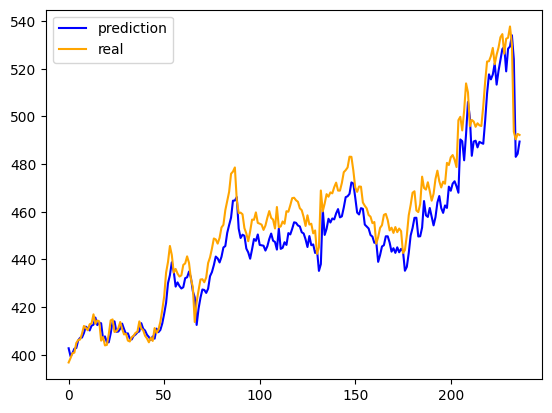

In [1490]:
import matplotlib.pyplot as plt
plt.plot(train_results['Test Predictions'][:], color='blue', label='prediction')
plt.plot(train_results['Actuals'][:], color='orange', label='real')
plt.legend()
plt.show()


91.84686705723546


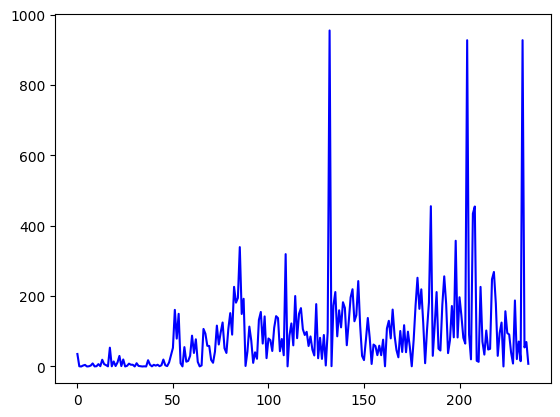

In [1491]:
plt.plot(np.abs(train_results['Test Predictions'][:]-train_results['Actuals'][:])**2, color='blue', label='prediction')
print(np.mean(np.abs(train_results['Test Predictions'][:]-train_results['Actuals'][:])**2))

In [1492]:
train_results.to_csv('test_results.csv', index=False)

# Load CSV into DataFrame
test_data = pd.read_csv('test_results.csv')

# Create a new column showing the difference
test_data['Difference'] = test_data['Test Predictions'] - test_data['Actuals']

# Calculate the difference from today to tomorrow for both columns
test_data['Predictions Difference'] = test_data['Test Predictions'].shift(-1) - test_data['Test Predictions']
test_data['Actuals Difference'] = test_data['Actuals'].shift(-1) - test_data['Actuals']

# Show the first few rows
test_data

,Test Predictions,Actuals,Difference,Predictions Difference,Actuals Difference
0,402.68980,396.730011,5.959789,-3.35480,1.849976
1,399.33500,398.579987,0.755013,1.27245,2.020020
2,400.60745,400.600006,0.007444,1.91195,0.269989
3,402.51940,400.869995,1.649405,0.28870,4.050018
4,402.80810,404.920013,-2.111913,3.16297,1.220001
...,...,...,...,...,...
232,534.03440,530.159973,3.874427,-10.04056,-36.619965
233,523.99384,493.540009,30.453831,-40.97244,-3.160004
234,483.02140,490.380005,-7.358605,1.27940,2.260010
235,484.30080,492.640015,-8.339215,5.13478,-0.445007


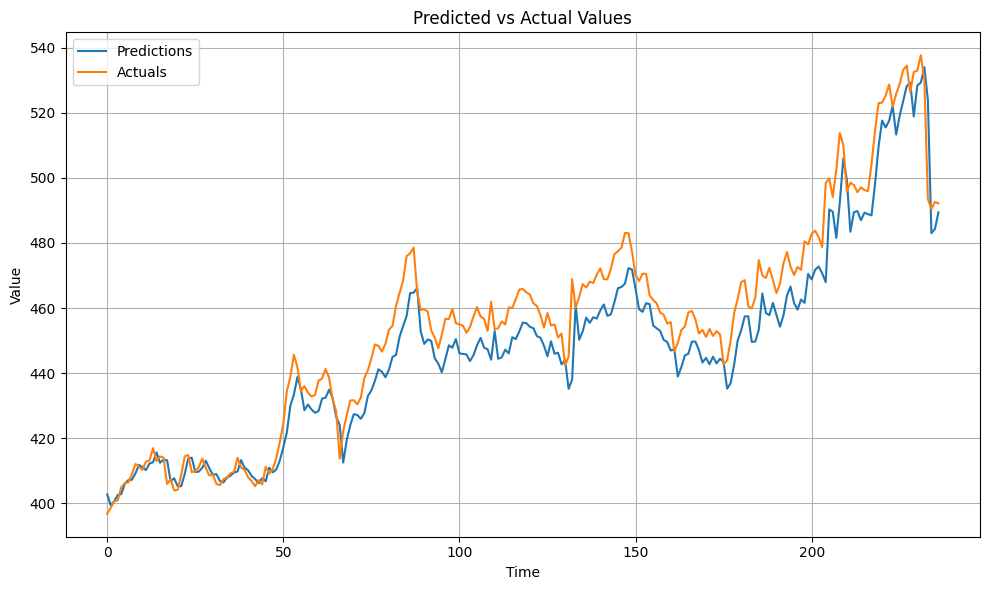

In [1493]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_data['Test Predictions'], label='Predictions')
plt.plot(test_data['Actuals'], label='Actuals')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

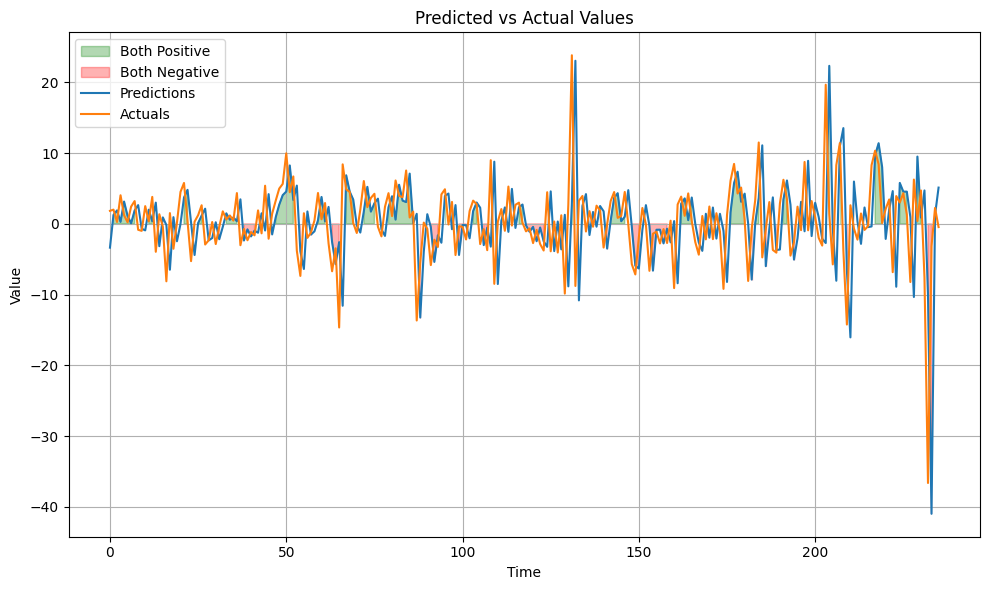

In [1494]:
# Plotting
plt.figure(figsize=(10, 6))

# Highlighting where both predictions and actuals are positive
plt.fill_between(range(len(test_data['Predictions Difference'])), 0, test_data['Predictions Difference'], where=(test_data['Predictions Difference'] > 0) & (test_data['Actuals Difference'] > 0), color='green', alpha=0.3, label='Both Positive')

# Highlighting where both predictions and actuals are negative
plt.fill_between(range(len(test_data['Predictions Difference'])), 0, test_data['Predictions Difference'], where=(test_data['Predictions Difference'] < 0) & (test_data['Actuals Difference'] < 0), color='red', alpha=0.3, label='Both Negative')

plt.plot(test_data['Predictions Difference'], label='Predictions')
plt.plot(test_data['Actuals Difference'], label='Actuals')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1495]:
start_money = 100
current_money = start_money
current_stocks = 0

pred_dif = test_data['Predictions Difference']
actuals = test_data['Actuals']
own_stock = False

for day in range(observations_in_one_stock-1):

    coeff = abs(pred_dif[day]/200)
    
    coeff = 1
    
    if coeff > 1:
        coeff = 1
    
    if pred_dif[day] < 0:
        #Sell       
        current_money += current_stocks * coeff * actuals[day]
        current_stocks = current_stocks * (1 - coeff)
        own_stock = False
        
    elif pred_dif[day] > 0:
        #Buy
            
        current_stocks += current_money * coeff / actuals[day]
        current_money = current_money * (1 - coeff)
        own_stock = True

current_money += current_stocks * actuals[day]
current_stocks = 0
own_stock = False
    
print("trading result", current_money)
print("yearly stock change", start_money*(actuals[observations_in_one_stock-1]/actuals[0]))


trading result 134.83262408541995
yearly stock change 124.06296314729275
